In [3]:
#Dependencies
from functools import partial
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import optuna
from optuna import create_study
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.distributions import IntDistribution, FloatDistribution
from optuna.samplers import TPESampler
from optuna import Trial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
X_full = pd.read_csv('/workspaces/2025SE-Mike.N-HSC-AT2/data/concrete_preprocessed.csv')
y = X_full['strength']
X = X_full.drop(['strength'], axis=1)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cement                           996 non-null    float64
 1   blast_furnace_slag               996 non-null    float64
 2   fly_ash                          996 non-null    float64
 3   water                            996 non-null    float64
 4   superplasticizer                 996 non-null    float64
 5   coarse_aggregate                 996 non-null    float64
 6   fine_aggregate                   996 non-null    float64
 7   age                              996 non-null    float64
 8   cement_to_water_ratio            996 non-null    float64
 9   fine_aggregate_to_water_ratio    996 non-null    float64
 10  coarse_aggregate_to_water_ratio  996 non-null    float64
dtypes: float64(11)
memory usage: 85.7 KB


In [6]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 996 entries, 0 to 995
Series name: strength
Non-Null Count  Dtype  
--------------  -----  
996 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


In [ ]:
model = RandomForestRegressor()
train_time = 60*15 

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=42)
# Define the callback to stop the optimization when the trial keep being pruned. 
# The number of pruned trials is defined by the threshold.
class StopWhenTrialKeepBeingPrunedCallback:
    def __init__(self, threshold: int):
        self.threshold = threshold
        self._consequtive_pruned_count = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.state == optuna.trial.TrialState.PRUNED:
            self._consequtive_pruned_count += 1
        else:
            self._consequtive_pruned_count = 0

        if self._consequtive_pruned_count >= self.threshold:
            study.stop()

# Define the objective function to optimize the hyperparameters of the XGBoost model.
def objective_forest(trial):
    params = {
        'criterion': 'absolute_error',
        'n_estimators': trial.suggest_int('n_estimators', 100, 4000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.1, 0.5),
        'max_features': trial.suggest_int('max_features', 1, 20),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.5),
    }


    model = RandomForestRegressor(random_state = 1, **params)
    
    model.fit(X_train, y_train)

    return model.score(X_val, y_val)

# Create the study and optimize the objective function.
# Threshold is 10.
study_stop_cb = StopWhenTrialKeepBeingPrunedCallback(10)
study_forest = create_study(direction="maximize", sampler = TPESampler(seed = 42))
study_forest.optimize(objective_forest, timeout = train_time, callbacks = [study_stop_cb])

study_forest.best_params

[I 2025-03-31 22:29:11,848] A new study created in memory with name: no-name-cc85353b-3477-4363-b400-a9121ac4a9f1


[I 2025-03-31 22:29:17,780] Trial 0 finished with value: 0.07998237580615253 and parameters: {'n_estimators': 1561, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.1624074561769746, 'max_features': 4, 'max_leaf_nodes': 15, 'min_impurity_decrease': 0.4330880728874676}. Best is trial 0 with value: 0.07998237580615253.
[I 2025-03-31 22:29:24,909] Trial 1 finished with value: 0.04787997224358753 and parameters: {'n_estimators': 2444, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.4329770563201687, 'max_features': 5, 'max_leaf_nodes': 26, 'min_impurity_decrease': 0.09170225492671691}. Best is trial 0 with value: 0.07998237580615253.
[I 2025-03-31 22:29:28,231] Trial 2 finished with value: 0.0458256441297098 and parameters: {'n_estimators': 1286, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.34474115788895177, 'max_features': 3, 'max_leaf_nodes': 36, 'mi

In [ ]:
base_model = RandomForestRegressor()
base_model.fit(X_train_valid, y_train_valid)
cross_val_score(base_model, X_train_valid, y_train_valid, scoring='neg_mean_absolute_error', cv = 5)

array([-10.66295393, -11.04066832, -10.56724292, -10.84772767,
        -9.86841151])

In [ ]:
plot_param_importances(study_forest)

In [ ]:
plot_optimization_history(study_forest)

In [ ]:
params = study_forest.best_params

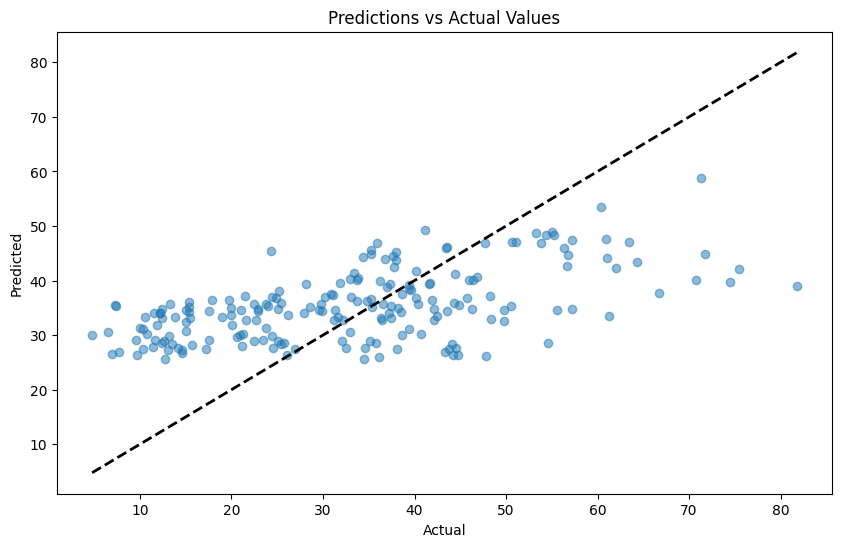

In [ ]:
model = RandomForestRegressor(**study_forest.best_params)
model.fit(X_train_valid, y_train_valid)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual Values')
plt.show()